In [1]:
!pip3 install uproot
!pip3 install mplhep

In [2]:
import uproot
import awkward
import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [3]:
def DeltaPhi(phi):
  """
  phi: pandas series
  """
  for i in range(len(phi)):
    if phi[i] >= np.pi:
      phi[i] -= 2*np.pi
    elif phi[i] < -1*np.pi:
      phi[i] += 2*np.pi 

  return phi  

def permutations():

  p = []
  for i in range(1,7):
    for j in range(1,7):
      if i != j and (j,i) not in p:
        p.append((i,j))

  return p

def invariant_mass(pt1, pt2, eta1, eta2, phi1, phi2):

  return np.sqrt(2*pt1*pt2*(np.cosh(eta1 - eta2) - np.cos(phi1 - phi2)))

def add_invariant_mass(df):

  # invariant mass
  df["inv_mass"] = invariant_mass(df["jet_pt1"],
                                  df["jet_pt2"],
                                  df["jet_eta1"],
                                  df["jet_eta2"],
                                  df["jet_phi1"],
                                  df["jet_phi2"])
  
  # max invariant mass
  aux_df = pd.DataFrame(index=np.arange(len(df)))

  for i,j in permutations():
    aux_df[f"{i,j}"] =  invariant_mass(df[f"jet_pt{i}"],
                                        df[f"jet_pt{j}"],
                                        df[f"jet_eta{i}"],
                                        df[f"jet_eta{j}"],
                                        df[f"jet_phi{i}"],
                                        df[f"jet_phi{j}"])
    
  df["max_inv_mass"] = np.max(aux_df, axis=1)

  return df

def delta_phi_met_jet(df):

  aux_df = pd.DataFrame(index=np.arange(len(df)))

  for i in range(1,7):
    phi = df[f"jet_phi{i}"] - df["missinget_phi"]
    aux_df[f"{i}"] = np.abs(DeltaPhi(phi))  
    
  df["min_delta_phi_met_jet"] = aux_df.min(axis=1)

  return df

def CutFlow(sig_cut, bac_cut, n_cuts=8, ns=50000, nb=50000, L=25000, sigmab=72.38, sigmas=13.76):
    """
    Returns the cut flow tables

    sig_cut,bac_cut:  dictionaries with the signal 
                      and background cuts
    cut_keys:         dictionary with the cuts keys
    n_cuts:           number of available cuts 
    L:                integrated luminosity in pb^-1
    
    ns,nb:            number of signal and background events
    
    sigmas,sigmab:    cross sections for the signal and
                      background events in pb

    """
    deltaEta_cut_value = 0
    invmass_cut_value = 1000
    met_cut_value = 200
    h_cut_value = 200
    delta_phi_cut_value = 0.5

    cut0 = "No cuts"
    cut1 = f"$\mathbf{{H_t >}}{h_cut_value}$"
    cut2 = "$n_jets \geq 2$"
    cut3 = f"$\mathbf{{P_T>30}}$, $|\eta(j)|<5$"
    cut4 = "$\eta (j_1) * \eta (j_2) < 0$"
    cut5 = f"$|\Delta \eta (j_1,j_2)| > {deltaEta_cut_value}$"
    cut6 = f"$\mathbf{{\text{max}M(j_1,j_2) >}}{invmass_cut_value}$"
    cut7 = f"|$\Delta\phi(\text{{MET}},j)| > {delta_phi_cut_value}$"

    math_cuts = [cut0,
                 cut1,
                 cut2,
                 cut3,
                 cut4,
                 cut5,
                 cut6,
                 cut7]

    cut_keys = {f"cut{i}":key for i,key in zip(range(8), math_cuts)}
    
    # number of applied cuts
    N_cuts = np.count_nonzero(list(s_cuts.values()))

    # modified cut dics
    s_cut = {key:value for key, value in zip(sig_cut.keys(), sig_cut.values()) if value !=0}
    b_cut = {key:value for key, value in zip(bac_cut.keys(), bac_cut.values()) if value !=0}
    c_keys = {f"cut{i}":cut_keys[f"cut{i}"] for i in range(N_cuts)}

    # weights for signal and background events
    ws = L*sigmas/ns
    wb = L*sigmab/nb

    # dataframes
    s1 = pd.Series(s_cut, dtype="float64") if N_cuts!=8 else pd.Series(sig_cut, dtype="float64")
    s2 = pd.Series(b_cut, dtype="float64") if N_cuts!=8 else pd.Series(bac_cut, dtype="float64")
    s3 = pd.Series(c_keys) if N_cuts!=8 else pd.Series(cut_keys) 

    # cut flow tables
    df1 = pd.concat([s3,s1,s2], axis=1, keys=["${\textbf{[bold]: GeV}}$","S","B"])
    
    df1["Z"] = ws*df1["S"]/np.sqrt(ws*df1["S"]+wb*df1["B"]) 

    df2 = pd.DataFrame(index=[f"cut{i}" for i in range(N_cuts)],
                       columns=["${\\textbf{[bold]: GeV}}$","s_c","s_r","b_a","b_r"])

    for i in range(N_cuts):
      df2.iloc[i,0] = cut_keys[f"cut{i}"]

    for i in range(1,5):
      df2.iloc[0,i] = 1

    for i in range(1, N_cuts):
      df2.iloc[i,1] = df1.iloc[i,1]/df1.iloc[0,1]
      df2.iloc[i,3] = df1.iloc[i,2]/df1.iloc[0,2]
      df2.iloc[i,2] = df1.iloc[i,1]/df1.iloc[i-1,1]
      df2.iloc[i,4] = df1.iloc[i,2]/df1.iloc[i-1,2]

    return df1, df2

In [4]:
def df_lower_names(df):

  df.columns = [name.lower().replace(".","_") for name in df.columns]

  return df

def pad(jet):

  for i in range(len(jet)):
    while len(jet[i]) < 6:
      jet[i] = np.hstack((jet[i], [None]))

  return jet

def read_jet_branch(data, branch_name):

  return pad([jet[:6] for jet in data.array(branch_name)])

def get_jet_dic(jet, name):

  jets = {f"{name}{i}":[] for i in range(1,7)} 

  for jet in jet:
    for i in range(6):
      jets[f"{name}{i+1}"].append(jet[i])

  return jets

  {"jet_pt1":[], "jet_pt2":[]}

def get_jet_series(jet_var, name):

  keys = [name+f"{i}" for i in range(1,7)]
  
  return [pd.Series(jet_var[name], name=name) for name in keys]

def get_jet_dataframe(data, *branch_names):

  jet_keys = [key for key in branch_names if "Jet" in key]
  jets = {key:read_jet_branch(data, key) for key in jet_keys}

  names = [name for name in jets]

  jet_columns = {name:get_jet_series(get_jet_dic(jets[name], name), name) for name in names}

  df = pd.DataFrame(index=np.arange(len(jets[names[0]])))

  for key in jet_columns.keys():
    for i in range(6):
      df = df.join(jet_columns[key][i])

  # adding number of jets to dataframe
  n_jets = [np.count_nonzero(jet) for jet in jets[jet_keys[0]]]
  df["n_jets"] = n_jets

  return df_lower_names(df) 

def get_nonjet_dataframe(data, *branch_names):

  df_keys = [key for key in branch_names if "Jet" not in key]
  df = data.arrays(branches=[*df_keys], outputtype=pd.DataFrame).astype("float64")

  return df_lower_names(df)

def get_dataframe(data, *branch_names):

  # non-jet df
  nonjet_df = get_nonjet_dataframe(data, *branch_names)

  # jet df
  jet_df = get_jet_dataframe(data, *branch_names)

  # joining dataframes
  df = nonjet_df.join(jet_df)

  # adding H
  jets_pt = [f"jet_pt{i}" for i in range(1,7)]
  df["H"] = df[jets_pt].sum(axis=1)

  if "Jet.Phi" in branch_names:
    pt1, pt2 = df["jet_pt1"], df["jet_pt2"] 
    eta1, eta2 = df["jet_eta1"], df["jet_eta2"]
    phi1, phi2 = df["jet_phi1"], df["jet_phi2"]

    # adding invariant mass 
    df = add_invariant_mass(df)  

    # adding deltaPhi for leading jets
    df["delta_phi"] = np.abs(DeltaPhi(phi1 - phi2))

    # adding min deltaPhi for met and jets
    df = delta_phi_met_jet(df)

  return df

In [5]:
# Cuts

def cut1(df, cuts):

  # H > 200
  mask = df.H > 200
  df = df.loc[mask,:]
  cuts["cut1"] = len(df)

  return df

def cut2(df, cuts):

  # at least two jets per event 
  mask = df.n_jets >=2
  df = df.loc[mask,:]
  cuts["cut2"] = len(df)

  return df

def cut3(df, cuts):

  # pt > 30 GeV and |eta| < 5 for leading and subleading jets  
  mask = (df.jet_pt1 > 30) & (df.jet_pt2 > 30) & (abs(df.jet_eta1) < 5) & (abs(df.jet_eta2) < 5) 
  df = df.loc[mask,:]
  cuts["cut3"] = len(df)

  return df

def cut4(df, cuts):

  # leading jets in opposite hemispheres
  n = len(df)
  mask = df.jet_eta1 * df.jet_eta2 < 0
  df = df.loc[mask,:]
  cuts["cut4"] = len(df)

  return df

def cut5(df, cuts):

  # |DeltaPhi| >= 2.3 for leading jets
  n = len(df)
  mask = abs(df.delta_phi) >= 2.3
  df = df.loc[mask,:]
  cuts["cut5"] = len(df)

  return df

def cut6(df, cuts):

  # max invariant mass >= 1000
  n = len(df)
  mask = df.max_inv_mass >= 1000
  df = df.loc[mask,:]
  cuts["cut6"] = len(df)

  return df

def cut7(df, cuts):

  # min deltaPhi met jet < 0.5
  n = len(df)
  mask = df.min_delta_phi_met_jet <= 0.5
  df = df.loc[mask,:]
  cuts["cut7"] = len(df)

  return df

def Cuts(df, n_cuts=3):

  cuts = {"cut0":len(df)}

  while True:

    df = cut1(df, cuts) 
    if n_cuts == 1: break
    
    df = cut2(df, cuts) 
    if n_cuts == 2: break

    df = cut3(df, cuts) 
    if n_cuts == 3: break
  
    df = cut4(df, cuts)
    if n_cuts == 4: break

    df = cut5(df, cuts)
    if n_cuts == 5: break  

    df = cut6(df, cuts)
    if n_cuts == 6: break

    df = cut7(df, cuts)
    if n_cuts == 7: break

  return df, cuts

## Reading the data

In [6]:
signal_path = "/content/drive/Shared drives/VBF_DM_UdeA/Samples/DMSimp_spin0/DMSimpSpin0_MY5000_MX1000_07042020.root"
back_path = "/content/drive/Shared drives/VBF_DM_UdeA/Samples/ZjetstoNuNu/santiago_run_02.root"

signal = uproot.open(signal_path)["Delphes"]
background = uproot.open(back_path)["Delphes"]

In [7]:
ns = signal.numentries
nb = background.numentries
ns, nb  

(34079, 48983)

In [8]:
signal_df = get_dataframe(signal, "Jet.PT", "MissingET.Phi", "MissingET.MET", "Jet.Eta", "MissingET.Eta", "Jet.Phi")
signal_df.head()

,missinget_phi,missinget_met,missinget_eta,jet_pt1,jet_pt2,jet_pt3,jet_pt4,jet_pt5,jet_pt6,jet_eta1,jet_eta2,jet_eta3,jet_eta4,jet_eta5,jet_eta6,jet_phi1,jet_phi2,jet_phi3,jet_phi4,jet_phi5,jet_phi6,n_jets,H,inv_mass,max_inv_mass,delta_phi,min_delta_phi_met_jet
entry,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.941587,198.476883,-1.974154,2611.700928,2441.109131,27.122381,24.460632,NaN,NaN,0.221878,0.454984,-1.725778,-4.362590,NaN,NaN,-1.361408,1.773167,-1.822483,0.463085,NaN,NaN,4,5104.393072,5084.238182,5084.238182,3.134575,0.168419
1,3.070084,472.074036,2.398561,2121.402100,978.568481,689.595154,127.363510,54.118202,31.619173,0.636775,-1.687332,-1.097037,-0.162019,-2.046714,1.450148,0.035726,2.912283,-2.657105,-2.935772,0.995352,-1.124620,6,4002.666620,5041.931636,5041.931636,2.876557,0.157800
2,2.243740,136.096527,1.026938,2065.143311,1989.540527,185.702072,33.396263,31.183512,27.978081,-0.682895,0.801429,1.438716,1.087488,-0.064997,-3.594976,-0.760110,2.462105,0.558904,-2.969895,-0.984633,1.039194,6,4332.943766,5220.093516,5220.093516,3.060970,0.218366
3,1.529968,111.293030,-3.544397,1088.256348,884.074890,173.269272,105.409721,NaN,NaN,-0.999445,1.971797,-1.120732,-0.535773,NaN,NaN,0.468415,-2.658156,-2.657426,-2.043704,NaN,NaN,4,2251.010231,4555.191351,4555.191351,3.126571,1.061553
4,-0.234490,180.646027,0.805272,2405.073486,2305.290283,203.498428,67.993507,37.768810,NaN,0.337557,-0.377161,-1.485815,2.009343,0.940916,NaN,2.937418,-0.235848,2.139558,-1.329002,-0.338599,NaN,5,5019.624516,5012.667438,5012.667438,3.109920,0.001358


In [9]:
background_df = get_dataframe(background, "Jet.PT", "MissingET.Phi", "MissingET.MET", "Jet.Eta", "MissingET.Eta", "Jet.Phi")
background_df.head()

,missinget_phi,missinget_met,missinget_eta,jet_pt1,jet_pt2,jet_pt3,jet_pt4,jet_pt5,jet_pt6,jet_eta1,jet_eta2,jet_eta3,jet_eta4,jet_eta5,jet_eta6,jet_phi1,jet_phi2,jet_phi3,jet_phi4,jet_phi5,jet_phi6,n_jets,H,inv_mass,max_inv_mass,delta_phi,min_delta_phi_met_jet
entry,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.366152,193.045593,2.141622,152.318649,39.363121,29.562403,29.495722,24.590832,NaN,-1.597743,-1.037669,-1.930997,-2.367539,-3.098745,NaN,2.621554,-1.189232,-2.040686,2.471106,1.624462,NaN,5,275.330727,152.732100,152.732100,2.472399,0.823080
1,0.972984,143.555847,-0.350058,182.029037,38.346413,35.403255,NaN,NaN,NaN,-0.300222,-1.650878,-2.082046,NaN,NaN,NaN,-2.431831,-0.466523,0.309062,NaN,NaN,NaN,3,255.778706,184.708487,226.355776,1.965308,0.663923
2,-2.081107,192.820023,1.795612,189.976685,NaN,NaN,NaN,NaN,NaN,-0.186812,NaN,NaN,NaN,NaN,NaN,1.049339,NaN,NaN,NaN,NaN,NaN,1,189.976685,NaN,NaN,NaN,3.130446
3,-0.542933,147.749146,-1.219318,140.532578,NaN,NaN,NaN,NaN,NaN,0.963258,NaN,NaN,NaN,NaN,NaN,2.541014,NaN,NaN,NaN,NaN,NaN,1,140.532578,NaN,NaN,NaN,3.083947
4,-0.440342,174.776550,-1.924124,176.346802,NaN,NaN,NaN,NaN,NaN,1.327226,NaN,NaN,NaN,NaN,NaN,2.681762,NaN,NaN,NaN,NaN,NaN,1,176.346802,NaN,NaN,NaN,3.122104


## Applying cuts

In [10]:
s_df, s_cuts = Cuts(signal_df, n_cuts=7) 

In [11]:
b_df, b_cuts = Cuts(background_df, n_cuts=7)

In [12]:
t1, t2 = CutFlow(s_cuts, b_cuts)

In [13]:
t1

,${\textbf{[bold]: GeV}}$,S,B,Z
cut0,No cuts,34079.0,48983.0,165.494844
cut1,$\mathbf{H_t >}200$,34078.0,37739.0,185.340867
cut2,$n_jets \geq 2$,34078.0,35581.0,190.036154
cut3,"$\mathbf{P_T>30}$, $|\eta(j)|<5$",34078.0,33597.0,194.683350
cut4,$\eta (j_1) * \eta (j_2) < 0$,25746.0,14367.0,212.157650
cut5,"$|\Delta \eta (j_1,j_2)| > 0$",25508.0,3897.0,311.931435
cut6,"$\mathbf{\text<built-in function max>M(j_1,j_2...",25508.0,793.0,388.368204
cut7,"|$\Delta\phi(\text{MET},j)| > 0.5$",20521.0,299.0,362.124249


In [14]:
t2

,${\textbf{[bold]: GeV}}$,s_c,s_r,b_a,b_r
cut0,No cuts,1,1,1,1
cut1,$\mathbf{H_t >}200$,0.999971,0.999971,0.770451,0.770451
cut2,$n_jets \geq 2$,0.999971,1,0.726395,0.942818
cut3,"$\mathbf{P_T>30}$, $|\eta(j)|<5$",0.999971,1,0.685891,0.94424
cut4,$\eta (j_1) * \eta (j_2) < 0$,0.75548,0.755502,0.293306,0.427627
cut5,"$|\Delta \eta (j_1,j_2)| > 0$",0.748496,0.990756,0.0795582,0.271247
cut6,"$\mathbf{\text<built-in function max>M(j_1,j_2...",0.748496,1,0.0161893,0.20349
cut7,"|$\Delta\phi(\text{MET},j)| > 0.5$",0.60216,0.804493,0.00610416,0.377049


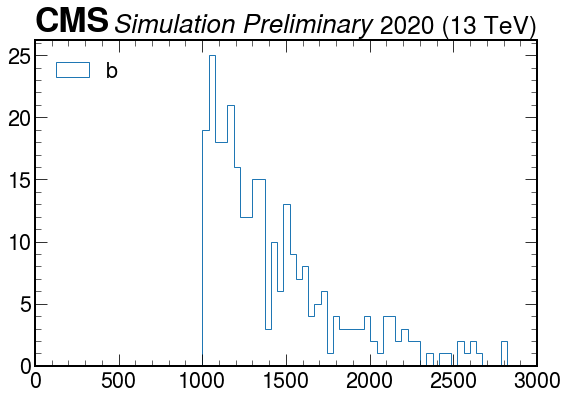

In [15]:
# set a CMS style 
plt.style.use(hep.style.CMS)

fig, ax = plt.subplots(1, figsize=(9,6))

#ax.hist(signal_df.met_met, histtype="step" ,bins=100, label="s", density=True)
ax.hist(b_df.max_inv_mass, histtype="step", bins=100, label="b")#, density=True);
ax.set_xlim(0,3000)

# set the figure title with CMS style info
hep.cms.label(data=False, paper=False, year='2020', ax=ax)
# set the figure title with (CMS style) some text 
#hep.cms.text("Preliminary")
plt.legend();